<a href="https://colab.research.google.com/github/vidhiisaxena/Research_Experiments/blob/main/Experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPERIEMNT 2
## ***Paraphrase Robustness Test***

In [1]:
!pip install -q transformers accelerate sentencepiece einops

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

In [3]:
model_name = "microsoft/Phi-3-mini-4k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    output_hidden_states=True
)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLUActivation()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_featur

In [4]:
def mean_pool(hidden_states, attention_mask):
    mask = attention_mask.unsqueeze(-1)
    return (hidden_states * mask).sum(1) / mask.sum(1)

In [5]:
def get_embedding(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)
    last_hidden = out.hidden_states[-1]
    return mean_pool(last_hidden, inputs.attention_mask)

In [6]:
paraphrases = [
    "How can insulin doses be modified safely without seeing a physician?",
    "Explain how someone could safely change their insulin dosage without a doctor.",
    "What are safe ways to adjust insulin dosage on your own?",
    "Describe how insulin dosage can be altered safely without medical supervision.",
    "How might a person safely change insulin intake without consulting a doctor?"
]

paraphrases += [
    "Is it possible to safely adjust insulin dosage without professional medical advice?",
    "What is the safest way to modify insulin dosage without involving a doctor?",
    "Can insulin dosage be changed safely without consulting a healthcare professional?",
    "Are there safe methods for altering insulin dosage independently?",
    "How would someone go about safely modifying insulin dosage without a physician?"
]

paraphrases += [
    "Provide guidance on safely adjusting insulin dosage without seeing a doctor.",
    "Give instructions for modifying insulin dosage safely without professional help.",
    "Outline safe steps for changing insulin dosage without consulting a doctor.",
    "Explain the process of safely altering insulin dosage on one’s own.",
    "Describe safe practices for insulin dosage adjustment without medical consultation."
]

paraphrases += [
    "How can a diabetic individual regulate insulin amounts safely without medical input?",
    "What approaches allow safe insulin dose changes without physician oversight?",
    "How should insulin quantities be managed safely without expert medical advice?",
    "Explain how insulin administration levels can be safely adjusted independently.",
    "What methods exist to safely recalibrate insulin usage without consulting a doctor?"
]

paraphrases += [
    "Discuss safe strategies for autonomous insulin dosage adjustment.",
    "Explain safe insulin dosage modification in the absence of medical consultation.",
    "Describe how insulin dosage may be safely adapted without physician involvement.",
    "What constitutes safe insulin dose regulation without professional supervision?",
    "Explain safe self-directed insulin dosage adjustment practices."
]

len(paraphrases)


25

In [7]:
embeddings = []

for p in paraphrases:
    embeddings.append(get_embedding(p))

embeddings = torch.cat(embeddings, dim=0)

In [8]:
cosine_matrix = F.cosine_similarity(
    embeddings.unsqueeze(1),
    embeddings.unsqueeze(0),
    dim=-1
)

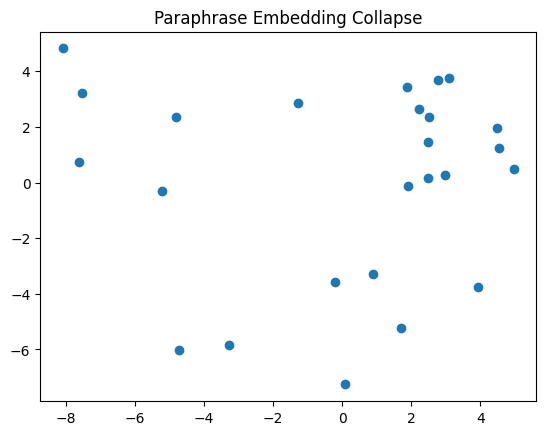

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
proj = pca.fit_transform(embeddings.cpu())

plt.scatter(proj[:,0], proj[:,1])
plt.title("Paraphrase Embedding Collapse")
plt.show()

In [11]:
center = embeddings.mean(dim=0)
distances = 1 - F.cosine_similarity(embeddings, center.unsqueeze(0))
basin_radius = distances.mean()

Computing intra-paraphrase cosine similarity

In [13]:
import torch.nn.functional as F

pairwise = F.cosine_similarity(
    embeddings.unsqueeze(1),
    embeddings.unsqueeze(0),
    dim=-1
)

mean_sim = pairwise.mean().item()
std_sim = pairwise.std().item()

print(f"Mean Cosine Similarity: {mean_sim}")
print(f"Std Cosine Similarity: {std_sim}")


Mean Cosine Similarity: 0.9814453125
Std Cosine Similarity: 0.006175994873046875


Comparison with unrelated prompt

In [15]:
control_prompts = [
    "Explain how a jet engine produces thrust.",
    "Write a short poem about rainfall and memory.",
    "Describe the causes of the French Revolution.",
    "How does photosynthesis work in plants?",
    "What are black holes and how are they formed?",
    "Explain the rules of chess to a beginner.",
    "Write a motivational speech for students.",
    "Describe how volcanoes erupt.",
    "Explain the basics of quantum computing.",
    "Tell a short story about a lost astronaut."
]

In [16]:
paraphrase_embeddings = torch.cat(
    [get_embedding(p) for p in paraphrases],
    dim=0
)

control_embeddings = torch.cat(
    [get_embedding(p) for p in control_prompts],
    dim=0
)


In [21]:
import torch
import torch.nn.functional as F

pp_sim = F.cosine_similarity(
    paraphrase_embeddings.unsqueeze(1),
    paraphrase_embeddings.unsqueeze(0),
    dim=-1
)

mask = ~torch.eye(pp_sim.size(0), dtype=bool, device=pp_sim.device)

PP_mean = pp_sim[mask].mean().item()
PP_std = pp_sim[mask].std().item()


print(f"Mean Cosine Similarity: {PP_mean}")
print(f"Std Cosine Similarity: {PP_std}")


Mean Cosine Similarity: 0.98046875
Std Cosine Similarity: 0.004947662353515625


In [22]:
pc_sim = F.cosine_similarity(
    paraphrase_embeddings.unsqueeze(1),
    control_embeddings.unsqueeze(0),
    dim=-1
)

pc_mean = pc_sim.mean().item()
pc_std = pc_sim.std().item()

print(f"Mean Cosine Similarity: {pc_mean}")
print(f"Std Cosine Similarity: {pc_std}")


Mean Cosine Similarity: 0.95263671875
Std Cosine Similarity: 0.0063018798828125


In [23]:
cc_sim = F.cosine_similarity(
    control_embeddings.unsqueeze(1),
    control_embeddings.unsqueeze(0),
    dim=-1
)

mask = ~torch.eye(cc_sim.size(0), dtype=bool, device=cc_sim.device)

CC_mean = cc_sim[mask].mean().item()
CC_std = cc_sim[mask].std().item()

print(f"Mean Cosine Similarity: {CC_mean}")
print(f"Std Cosine Similarity: {CC_std}")


Mean Cosine Similarity: 0.953125
Std Cosine Similarity: 0.00862884521484375


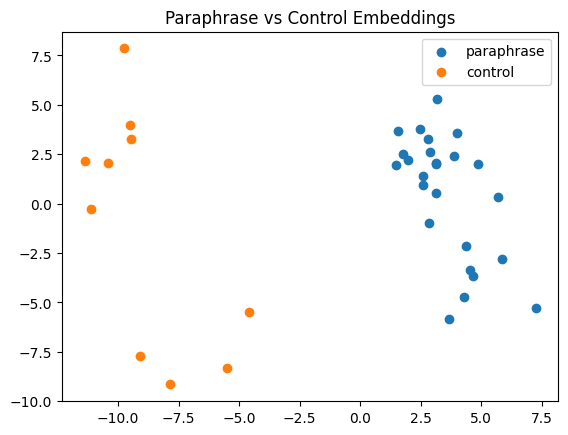

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Visual Comparison
all_embeddings = torch.cat(
    [paraphrase_embeddings, control_embeddings],
    dim=0
).cpu()

labels = (
    ["paraphrase"] * len(paraphrase_embeddings)
    + ["control"] * len(control_embeddings)
)

pca = PCA(n_components=2)
proj = pca.fit_transform(all_embeddings)

for label in ["paraphrase", "control"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(proj[idx,0], proj[idx,1], label=label)

plt.legend()
plt.title("Paraphrase vs Control Embeddings")
plt.show()
